In [446]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_packed_sequence
import matplotlib.pyplot as plt
import pandas as pd
import pickle

# if torch.cuda.is_available(): dev = "cuda"
dev = "cpu"

device = torch.device(dev)

In [447]:
# Hyperparameters
train_proportion = 0.80
hidden_dim = 50
learning_rate = 0.0001
batch_size = 64
epochs = 10000
n_layers = 1

In [448]:
with open("encoded_dataframe", "rb") as encoded_dataframe:
    encoded_df = pickle.load(encoded_dataframe)

embedding_dim = encoded_df[0][0][0].size(0)

In [449]:
# Shuffle data and split into training and testing data
train_dataset = encoded_df.sample(frac = train_proportion)
test_dataset = encoded_df.drop(train_dataset.index)

train_size = train_dataset.shape[0]
test_size = test_dataset.shape[0]

train_tensor = torch.utils.data.TensorDataset(
    torch.stack(tuple(train_dataset[0])).type(torch.float32).to(device),
    torch.stack(tuple(train_dataset[1])).to(device),
    torch.stack(tuple(train_dataset[2])).to(device))
test_tensor = torch.utils.data.TensorDataset(
    torch.stack(tuple(test_dataset[0])).type(torch.float32).to(device),
    torch.stack(tuple(test_dataset[1])).to(device),
    torch.stack(tuple(test_dataset[2])).type(torch.long).to(device))

train_loader = torch.utils.data.DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_tensor, batch_size = 1)

In [450]:
class LSTM_Classifier(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, n_layers, output_size, batch_size, drop_prob=0.5):
     
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, batch_first=True) # dropout=drop_prob,
        self.output_size = output_size
        #self.dropout = nn.Dropout(drop_prob)
        self.full_connected = nn.Linear(hidden_dim, output_size)
        
    def forward(self, batched_sequences, sentence_lengths):
        batched_sequences=pack_padded_sequence(batched_sequences, sentence_lengths, batch_first=True, enforce_sorted=False)
        lstm_out, _ = self.lstm(batched_sequences)
        lstm_out, _ = pad_packed_sequence(lstm_out, batch_first=True)
        output = lstm_out #self.dropout(lstm_out)
        output = self.full_connected(output)
        output = torch.gather(output, 1 ,torch.cat((sentence_lengths.unsqueeze(1), sentence_lengths.unsqueeze(1)), 1).unsqueeze(1)-1)
        return torch.squeeze(output, 1)

In [451]:
net = LSTM_Classifier(embedding_dim, hidden_dim, n_layers, 2, batch_size)

num_positive = 3685
num_negative = 2106

net.to(device)
weight = torch.FloatTensor([num_positive/num_negative, num_positive/num_positive]).to(device)

# Negative log likelihood loss. Suited for classification tasks.
criterion = F.nll_loss

optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0.00001)

In [452]:
def train(net, criterion, optimizer, data, label, lengths):

    loss = 0

    # Forward
    output = net(data, lengths)

    # Apply output nonlinearity. Log_softmax chosen as it is suited for classification tasks
    output = (F.log_softmax(output, dim=1))
    
    loss = criterion(output, torch.squeeze(label,1), weight=weight)

    loss.backward()

    optimizer.step()

    return loss.data.item()

In [453]:
plot_loss = []
plot_correct = []

num_batches = train_size//batch_size

for e in range(epochs):
    loss = 0.

    # Trains by batch
    for data, label, lengths in train_loader:
        optimizer.zero_grad()
        loss += train(net, criterion, optimizer, data, label, lengths)

    # Evaluate proportion of the test set correctly predicted.
    correct = 0
    for data, label, lengths in test_loader:
        output = net(data, lengths)
        if (torch.argmax(output.data) == label[0][0]): correct += 1
    accuracy = correct/test_size*100

    # Append loss and accuracy results to lists for later plotting.
    plot_loss.append(loss/num_batches)
    plot_correct.append(accuracy)
    
    # Print loss and accuracy every epoch.
    print("Epoch %02d, loss = %f, accuracy = %.2f%%" % (e+1, loss / num_batches, accuracy))

Epoch 01, loss = 0.703967, accuracy = 51.12%
Epoch 02, loss = 0.702855, accuracy = 62.18%
Epoch 03, loss = 0.702123, accuracy = 46.03%
Epoch 04, loss = 0.702091, accuracy = 59.67%
Epoch 05, loss = 0.702635, accuracy = 59.41%
Epoch 06, loss = 0.701602, accuracy = 48.19%
Epoch 07, loss = 0.701268, accuracy = 54.66%
Epoch 08, loss = 0.701258, accuracy = 55.44%
Epoch 09, loss = 0.700773, accuracy = 56.39%
Epoch 10, loss = 0.700711, accuracy = 55.70%
Epoch 11, loss = 0.700599, accuracy = 53.20%
Epoch 12, loss = 0.699857, accuracy = 46.03%
Epoch 13, loss = 0.700043, accuracy = 51.81%
Epoch 14, loss = 0.699448, accuracy = 56.74%
Epoch 15, loss = 0.699582, accuracy = 56.22%
Epoch 16, loss = 0.698366, accuracy = 55.44%
Epoch 17, loss = 0.697925, accuracy = 56.48%
Epoch 18, loss = 0.697757, accuracy = 49.31%
Epoch 19, loss = 0.697213, accuracy = 54.84%
Epoch 20, loss = 0.698460, accuracy = 57.08%
Epoch 21, loss = 0.696802, accuracy = 46.37%
Epoch 22, loss = 0.696480, accuracy = 53.63%
Epoch 23, 

KeyboardInterrupt: 

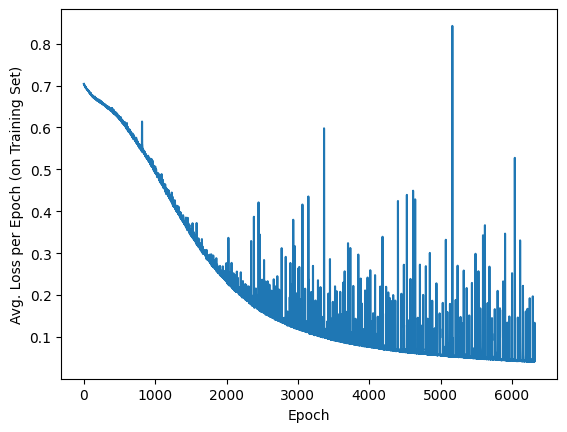

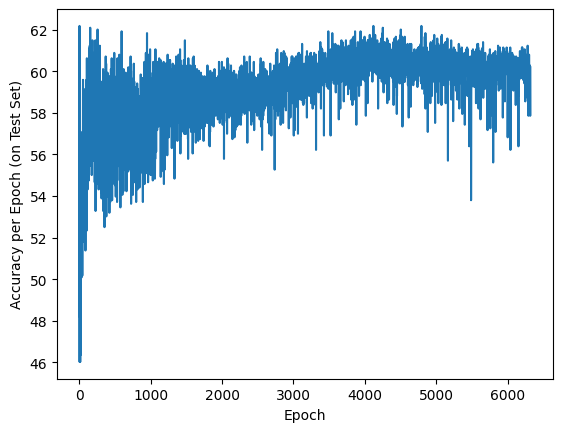

In [454]:
# Plot results
plt.plot(plot_loss)
plt.xlabel('Epoch')
plt.ylabel('Avg. Loss per Epoch (on Training Set)')
plt.show()

plt.plot(plot_correct)
plt.xlabel('Epoch')
plt.ylabel('Accuracy per Epoch (on Test Set)')
plt.show()